# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [23]:
################################
#
# Import needed libraries
#
################################

from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

import networkx as nx
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time


# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.

In [43]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `goal_test` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def goal_test(self, state):         return state == self.goal
    def path_cost(self, c, s, a, s1):   return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.path_cost(node.path_cost, s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

# Search Methods

Below are the function calls for a few of the search methods from search.py python library.  You can look in the file to see more, or if your curious the details of how they work.

In [44]:
'''
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
   
def greedy_best_first_graph_search(problem, h=None):
    """Search nodes by minimizing h, where h=heuristic of how close to goal."""

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."

def breadth_first_graph_search(problem):
    "Search shallowest nodes in the search tree first; using best-first."

def depth_first_graph_search(problem):
    "Search deepest nodes in the search tree first; using best-first."

def astar_search(problem, h=None):
    """Search nodes using A*, where h=heuristic."""
'''

'\ndef best_first_search(problem, f):\n    "Search nodes with minimum f(node) value first."\n   \ndef greedy_bfs(problem, h=None):\n    """Search nodes by minimizing h, where h=heuristic of how close to goal."""\n\ndef uniform_cost_search(problem):\n    "Search nodes with minimum path cost first."\n\ndef breadth_first_bfs(problem):\n    "Search shallowest nodes in the search tree first; using best-first."\n\ndef depth_first_bfs(problem):\n    "Search deepest nodes in the search tree first; using best-first."\n\ndef astar_search(problem, h=None):\n    """Search nodes using A*, where h=heuristic."""\n'

# Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

# Route Finding - Romania

![](images/romania_map.png)

In a `RouteProblem`, the states are names of "cities" (or other locations), like `'A'` for Arad. The actions are also city names; `'Z'` is the action to move to city `'Z'`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.


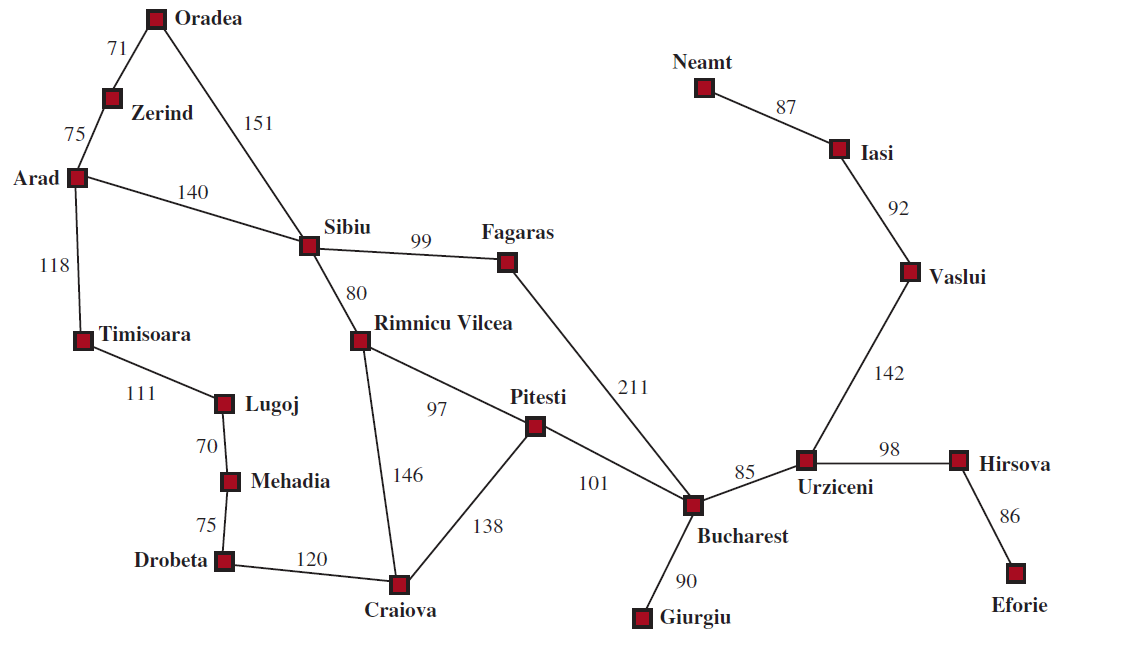

In [49]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def goal_test(self, state):
        """ Given a state, return True if state is a goal state or False, otherwise """
        return state == self.goal
    
    def path_cost(self, c, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [50]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [185]:
# Some specific RouteProblems

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('N', 'L', map=romania)
r2 = RouteProblem('E', 'T', map=romania)
r3 = RouteProblem('O', 'M', map=romania)

In [204]:
path_states(uniform_cost_search(r2))

['E', 'H', 'U', 'B', 'P', 'C', 'D', 'M', 'L', 'T']

In [205]:
path_states(astar_search(r2,r2.h))

['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']

In [ ]:
############# Add some search methods here ##################################



# 8 Puzzle Problems

![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

A sliding tile puzzle where you can swap the blank with an adjacent piece, trying to reach a goal configuration. The cells are numbered 0 to 8, starting at the top left and going row by row left to right. The pieces are numebred 1 to 8, with 0 representing the blank. An action is the cell index number that is to be swapped with the blank (*not* the actual number to be swapped but the index into the state). So the diagram above left is the state `(5, 2, 7, 8, 4, 0, 1, 3, 6)`, and the action is `8`, because the cell number 8 (the 9th or last cell, the `6` in the bottom right) is swapped with the blank.

There are two disjoint sets of states that cannot be reached from each other. One set has an even number of "inversions"; the other has an odd number. An inversion is when a piece in the state is larger than a piece that follows it.

In [199]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
         
    def h1(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
    
    
    #### Add another heuristic here ################


def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height) 
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty
        
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

In [200]:
# Some specific EightPuzzle problems

e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [201]:
# Solve an 8 puzzle problem and print out each state

steps=0
for s in path_states(astar_search(e1, e1.h1)):
    print(board8(s))
    steps+=1
    
print("Path Cost:", steps)

1 4 2
_ 7 5
3 6 8

1 4 2
3 7 5
_ 6 8

1 4 2
3 7 5
6 _ 8

1 4 2
3 _ 5
6 7 8

1 _ 2
3 4 5
6 7 8

_ 1 2
3 4 5
6 7 8

Path Cost: 6


In [206]:
#### Test your new heuristic here, compare to manhattan distance ################

